# TWITTER BOT DETECTION

### Import Packages

In [1]:
# Packages required for handling data.
import pandas as pd
import numpy as np
import json
import string
from collections import Counter


# Packages required for plotting.
import matplotlib.pyplot as plt
import seaborn as sns

# Packages required for model building.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb

# Packages required for evaluations.
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Packages required for fine tuning the models.
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import FitFailedWarning 
from sklearn.model_selection import GridSearchCV, KFold

### Functions

In [2]:
# Plots a scatter graph for the given data.
# Input - Input data along with graph title and data labels.
# Output - None, just displays the graph.
def draw_scatterplot(x,y,c, x_label, y_label, plot_title):
    fig, ax = plt.subplots()
    scatter = ax.scatter(x, y, c=c, s=10, cmap='bwr')
    # produces a legend with the unique colors from the scatter
    legend = ax.legend(*scatter.legend_elements(),
                        loc="lower right", title="Classes")
    ax.add_artist(legend)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.show()
    

# Plots a histogram graph for the given data.
# Input - Input data along with graph title and data labels.
# Output - None, just displays the graph.
def draw_histplot(x,c,data, x_label, y_label, plot_title):
    plt.figure(figsize=(7,4))
    sns.histplot(binwidth=0.5, x=x, hue=c, data=data, stat="count", multiple="stack")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.show()
    


# Utility fuction - Converts date from string format to integer, extracts and returns year.
# Input - Date in string format.
# output - Year in integer format.
def get_year(date_str):
    if "/" in date_str:
        return int(date_str.split('/')[-1].split(" ")[0].strip('"'))
    if "+" in date_str:
        return int(date_str.split(" ")[-1].strip('"'))
    
     

# Plots the Confusion Matrix if plot_metrics is "True" else it does not.
# Computes all the evaluation metrics such as F1 score, Precision, Recall and Accuracy.
# Input - Predicted and Actual values along with plot_metrics indicator.
# Output- Returns the Evaluation metric scores.
def get_metrics(preds, actuals, plot_metrics=False):
    # plots the confusion matric if "plot_metrics" is "true". 
    if plot_metrics:
        cm = confusion_matrix(preds, actuals)
        plt.figure(figsize=(2, 2))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Reds', 
                    xticklabels=["Not Bot", "Bot"], yticklabels=["Not Bot", "Bot"], cbar=False)       
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()
    
    # Computing the Evaulation metric scores.
    curr_f1_score = round(f1_score(preds, actuals), 2)
    curr_precision_score = round(precision_score(preds, actuals), 2)
    curr_recall_score = round(recall_score(preds, actuals), 2)
    curr_accuracy_score = round(accuracy_score(preds, actuals), 2)

    # Display the computed Evaulation metric scores.
    print(f"F1 Score {curr_f1_score}")
    print(f"Precision Score {curr_precision_score}")
    print(f"Recall Score {curr_recall_score}")
    print(f"Accuracy Score {curr_accuracy_score}")

    # Return the computed Evaulation metric scores.
    return {"f1_score" : curr_f1_score,
            "precision_score" : curr_precision_score,
            "recall_score" : curr_recall_score,
            "accuracy_score": curr_accuracy_score}
    
    
# The fuction fits the data splits to a given model instance.
# It inturn calls get_metrics() to get the evaulation metrics scores.
# Then computes ROC and AUC scores and stores all the metric scores for train and test in an array.
# Input - Model instance, train and test splits, along with model decription and plot_metrics indicator.
# Output - Returns train_metrics and test_metrics dictionary with all the details of Evaultion metrics, 
#          along with ROC and AUC scores. 
def fit_model_and_run_preds(model, X_train, y_train, X_test, y_test, model_desc, plot_metrics=False):
    model.fit(X_train, y_train)
    # Call predict() method for both train and test data feature set
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Call predict_proba() method for both train and test data feature set.
    # predict_proba() computes probabilities and returns an array of lists containing the class probabilities for the input data points
    train_pred_proba = model.predict_proba(X_train)[::,1]  # 1 because we focus on positive class
    test_pred_proba = model.predict_proba(X_test)[::,1]
    
    # Call get_metrics() to plot confusion matrix and to compute and display evaluation metrics for both train and test data.
    print("Train Metrics")
    train_metrics = get_metrics(train_preds, y_train, plot_metrics)
    print("\n")
    print("Test Metrics")
    test_metrics = get_metrics(test_preds, y_test, plot_metrics)
    
    # Computes ROC curve for train and test data.
    train_fpr, train_tpr, _ = roc_curve(y_train,  train_pred_proba)
    test_fpr, test_tpr, _ = roc_curve(y_test,  test_pred_proba)
    
    # Compute Area Under the curve(AUC) score for both train and test data.
    train_auc = roc_auc_score(y_train, train_pred_proba)    
    test_auc = roc_auc_score(y_test, test_pred_proba)
    
    # Store metric information for train data in an dictionary.
    train_metrics['y_pred'] = train_preds
    train_metrics['y_pred_proba'] = train_pred_proba   
    train_metrics['fpr'] = train_fpr   
    train_metrics['tpr'] = train_tpr   
    train_metrics['auc'] = train_auc
    train_metrics['model_desc'] = model_desc
    
    # Store metric information for test data in an dictionary.
    test_metrics['y_pred'] = test_preds
    test_metrics['y_pred_proba'] = test_pred_proba
    test_metrics['fpr'] = test_fpr
    test_metrics['tpr'] = test_tpr
    test_metrics['auc'] = test_auc
    test_metrics['model_desc'] = model_desc
    
    # Return all metric dictionaries for train and test data.
    return train_metrics, test_metrics

# Data Reading and Processing

In [3]:
# Read data set in csv format using panda's read_csv() method
full_data = pd.read_csv("full_data.csv")
full_data.head(1)

,id,id_str,screen_name,location,description,url,followers_count,friends_count,listed_count,created_at,favourites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot
0,8.160000e+17,"""815745789754417152""","""HoustonPokeMap""","""Houston, TX""","""Rare and strong PokŽmon in Houston, TX. See m...","""https://t.co/dnWuDbFRkt""",1291,0,10,"""Mon Jan 02 02:25:26 +0000 2017""",0,False,78554,"""en""","{\r ""created_at"": ""Sun Mar 12 15:44:04 +0...",True,False,False,"""Houston PokŽ Alert""",1


In [4]:
### Checking null value count
full_data.isna().sum()

id                          0
id_str                      0
screen_name                 0
location                 1020
description               403
url                      1342
followers_count             0
friends_count               0
listed_count                0
created_at                  0
favourites_count            0
verified                    0
statuses_count              0
lang                        0
status                    289
default_profile             0
default_profile_image       0
has_extended_profile       99
name                        0
bot                         0
dtype: int64

In [5]:
### Checking column data types
full_data.dtypes

id                       float64
id_str                    object
screen_name               object
location                  object
description               object
url                       object
followers_count            int64
friends_count              int64
listed_count               int64
created_at                object
favourites_count           int64
verified                    bool
statuses_count             int64
lang                      object
status                    object
default_profile             bool
default_profile_image       bool
has_extended_profile      object
name                      object
bot                        int64
dtype: object

## Feature Engineering and Cleaning

In [6]:
### Dropping 'id_str' column as we already have id column.
full_data.drop('id_str', axis=1,inplace=True)

### Screen 
Extracted "screen_name_length" feature from "screen_name" and then dropped "screen_name" feature.

In [7]:
# Computing count of distinct values in "screen_name" feature.
full_data['screen_name'].value_counts()

GenerateACat       2
pentametron        2
greatartbot        2
SciTechRangers     2
cihpom             2
                  ..
IAM_SHAKESPEARE    1
BrunoTSaraiva      1
TheAlotShepherd    1
xiehl16            1
RepJoeBarton       1
Name: screen_name, Length: 2789, dtype: int64

In [8]:
# Computing length of each "screen_name" value and storing in "screen_name_length" feature.
full_data["screen_name_length"] = full_data['screen_name'].apply(lambda x: len(x))
# Dropping "screen_name" feature.
full_data.drop('screen_name', axis=1, inplace=True)

### Name
Extracted "name_length", "name_has_top_words", "name_has_bot" features from "name" feature and dropped "name" feature.
- name_length - Indicates the number of characters in name.
- name_has_top_words - After getting the top frequently used words in all the names combined. And extracted a feature to indicate if the name includes most frequently used words.
- name_has_bot - Indicates if the name has "bot" mentioned in it.

In [9]:
# Computing count of distinct values in "name" feature.
full_data['name'].value_counts()

free follow            5
Statement Artist       2
Lia                    2
Justin                 2
Lily                   2
                      ..
The Alot Shepherd      1
xiehl16                1
ASKING FOR A FRIEND    1
Thomas Sabo            1
Joe Barton             1
Name: name, Length: 2769, dtype: int64

In [10]:
## Covert to lower case and strip ", " ", . and ,
all_names = full_data['name'].apply(lambda x: x.lower().strip('"/ /./,')).values

In [11]:
all_names = " ".join(all_names)
# Count most common names amongst the names in data.
all_words_counter = Counter(all_names.split(" "))
all_words_counter.most_common(5)

[('bot', 127), ('the', 62), ('papers', 33), ('of', 26), ('every', 21)]

In [12]:
top_15_words_name = [i[0] for i in all_words_counter.most_common(15) if i[0] not in stop_words]
bot_words = [i[0] for i in all_words_counter.most_common(1000) if 'bot' in i[0]]

In [13]:
# Computing length of each "name" value and storing in "name_length" feature.
full_data['name_length'] = full_data['name'].apply(lambda x: len(x.split(" ")))
full_data['name_has_top_words'] = full_data['name'].apply(lambda x: any([i in x.lower().strip('"/ /./,') for i in top_15_words_name]))
full_data['name_has_bot'] = full_data['name'].apply(lambda x: any([i in x.lower().strip('"/ /./,') for i in bot_words]))

In [14]:
full_data.head(3)

,id,location,description,url,followers_count,friends_count,listed_count,created_at,favourites_count,verified,...,status,default_profile,default_profile_image,has_extended_profile,name,bot,screen_name_length,name_length,name_has_top_words,name_has_bot
0,8.160000e+17,"""Houston, TX""","""Rare and strong PokŽmon in Houston, TX. See m...","""https://t.co/dnWuDbFRkt""",1291,0,10,"""Mon Jan 02 02:25:26 +0000 2017""",0,False,...,"{\r ""created_at"": ""Sun Mar 12 15:44:04 +0...",True,False,False,"""Houston PokŽ Alert""",1,16,3,False,False
1,4.843621e+09,"Templeville town, MD, USA",From late 2014 Socium Marketplace will make sh...,NaN,1,349,0,2/1/2016 7:37,38,False,...,NaN,True,False,False,Keri Nelson,1,9,2,False,False
2,4.303727e+09,NaN,"Inspired by the smart, funny folks at @replyal...",https://t.co/P1e1o0m4KC,1086,0,14,Fri Nov 20 18:53:22 +0000 2015,0,False,...,"{'retweeted': False, 'is_quote_status': False,...",True,False,False,Matt Lieber Is Bot,1,15,4,True,True


In [15]:
# Dropping "name" feature.
full_data.drop('name', axis=1, inplace=True)

### Location
Extracted "location_length", "location_has_spl_chars", "location_is_real" features from "location" feature.
- location_length - Indicates the number of characters in location.
- location_has_spl_chars - Indicates if the location has any special characters in it.
- location_is_real - Generated a list of all false locations in the "location" feature and used it to extract a feature to indicate if the location is real or fake.

In [16]:
junk_locations = ['#botALLY', 'Internet', 'The Art World', 'The Internets', 'Stratford-upon-Internet', '#botally', 'everywhere', 'space', 'Peripatetic', 'nowhere', 'On Tour', 'In a world of my own', 'STOICVILLE', 'wherever the squirrels are.',
 'the valley',  '"Am I? TELL MEE"', '0,0,1', 'Window seat', 'Time is the best MASTER....', 'All over the place!!', "In God's hands",
 'Just behind your right ear',' ', 'internet', '(Bot by @robdubbin)', 'working late', 'Deserts, Forests, Beaches, etc', 'Purification in Progress.', '_._______________, _________', 'cheese land', '____ __', 'anywhere',
 'tweets in parenthesis owner', 'An Imaginary Nursery', 'Libraries Everywhere', 'the seven seas', "Your Doctor's Office", '5th Dimension ',
 'ëÔë£ë_-‰_Ò•ü\x8f-Gamma Iota Advisor', 'in your DMs', 'Up and down', 'Collective Unconscious', 'anywhere and everywhere', 'robot kitchen', 'World 1-1', 'gritty reboot of the internet',
 'Microbiome', 'HELL', '_Ï__„\x81_¼___¡', 'All around', 'the icebox', 'Cat Cafí©', 'swatchspace', 'On the track', 'The Outer Planets',
 'A:\\', 'The back of ur blank check', 'World', 'chutes and shells', 'In the past', 'Twerking With Nick ;) ', 'sexy everywhere',
 'SPACE', 'Internet?', 'On Your Screen', 'The ancient web', 'Orion‰ÛÒCygnus Arm, Milky Way', 'in a machine.', 'soothing forest', 'Snowbird',
 'Namespace', 'Follow me; see grammar errors!', 'The Font of All Knowledge', 'funny town LOL', 'Dev: @Balbonator', 'The Present', 'IN UR HEAD WHEN U SLEEP', 'SPACESHIP', 'In your brain.', 'yeah', 'Out There', 'I am a GLOBAL SHIFTER! ', 'where am i not?', 'Driving in circles...', 'sssssss', 'sssssss', 'In My Skin. Out My Mind. ', 'i live in the universe, space, this solar system, earth the nesw aka news north east west south and etc ', 'monachopsis', 'Bot without Organs', "Earth's Core", 'where angels fear to tread', 'The Future', '94123', 'International', 'In your stuff', 'EVERYWHERE!!! ', 'omnipresent', 'Here', 'Planet Earth',
 '"___"', 'a bit all over the place', 'Worldwide ', 'Wheeling and Dealing!', 'on a beach...', 'On the Coast', 'It all depends on the day...', 'wherever I can race a car.', 'Everywhere Love IS', 'Somewhere Warm', 'We Are Everywhere.',
 'with my fur children.  ', 'Some where on Earth', '"_______"', 'http://summercampmars.com', 'shadowhunters academy',     'I like to move around a lot',     '...right behind you. ', 'Where the Cash At',
 'the long and winding road...', 'SOMEWHERE DRANKIN!! ', 'The Universe', 'At the crib dog', ' metaverse', 'asleep at a noise show']

In [17]:
# Replacing NaN or Null values with "".
full_data.location.fillna("", inplace=True)
full_data['location_length'] = full_data.location.apply(lambda x: len(x))

In [18]:
# Set special character threshold to 2
spl_char_threshold = 2
# Compute new feature "location_has_spl_chars" from "location" feature, by checking for each data point if it has more than threshold number of special characters.
full_data['location_has_spl_chars'] = full_data.location.apply(lambda x: sum([i in string.punctuation for i in x]) > spl_char_threshold)

In [19]:
full_data['location_is_real'] = full_data.location.apply(lambda x: x not in junk_locations)

In [20]:
# Dropping "location" feature.
full_data.drop('location', axis=1, inplace=True)

### Description
Replaced null values in "description" feature with empty strings; 
Extracted features "desc_has_top_words", "description_length", "desc_has_bot" from "description" feature.
- description_length - Indicates the number of words in description.
- desc_has_top_words - After getting the top frequently used words in all the descriptions combined and extracted a feature to indicate if the descriptions includes most frequently used word.
- desc_has_bot - Indicates if the "description" has bot mentioned in it.

In [21]:
# Checking number of NaN values in "description" feature.
full_data.description.isna().sum()

403

In [22]:
# Replacing NaN or Null values with "".
full_data.description.fillna("", inplace=True)

In [23]:
full_data.description

0       "Rare and strong PokŽmon in Houston, TX. See m...
1       From late 2014 Socium Marketplace will make sh...
2       Inspired by the smart, funny folks at @replyal...
3                                                        
4                  Inspiring cooks everywhere since 1956.
                              ...                        
2792    Twitter CMO. Favorite title: Mama. Never, ever...
2793    I live in brooklyn, I'm a bike messenger, I pl...
2794                                       astrophysicist
2795    I'm quite out of my mind, actually, but people...
2796    I work for the people of the 6th District of T...
Name: description, Length: 2797, dtype: object

In [24]:
full_data['description_length'] = full_data.description.apply(lambda x: len(x.split()))

In [25]:
## Covert to lower case and strip ", " ", . and ,
all_descriptions = full_data['description'].apply(lambda x: x.lower().strip('"/ /./,')).values  

In [26]:
all_descriptions = " ".join(all_descriptions)
all_descriptions_counter = Counter(all_descriptions.split(" "))
desc_freq_words = all_descriptions_counter.most_common(1000)

In [27]:
# Compute list of words that are in desc_freq_words and not in stop_words.
top_freq_words_desc = [i[0] for i in desc_freq_words if i[0] not in stop_words]
# Compute list of words from desc_freq_words that has 'bot' word in it and that word is not in stop_words.
bot_words_desc = [i[0] for i in desc_freq_words if 'bot' in i[0] and i[0] not in stop_words]

In [28]:
# Compute if each decription has top_freq_words_desc in them.
full_data['desc_has_top_words'] = full_data['description'].apply(lambda x: any([i in x.lower().strip('"/ /./,') for i in top_15_words_name]))
# Compute if each decription has bot_words_desc in them.
full_data['desc_has_bot'] = full_data['description'].apply(lambda x: any([i in x.lower().strip('"/ /./,') for i in bot_words]))

In [29]:
# Dropping "description" feature.
full_data.drop('description', axis=1, inplace=True)

### Language
Cleaned all the values in the language feature "lang", to remove double quotes(" ") and convert all values to lower case.

In [30]:
# Computing count of distinct values in "lang" feature
full_data.lang.value_counts()

en         2453
"en"        100
pt           76
en-gb        56
es           29
fr           14
de           10
it            8
"ja"          6
ja            5
ar            5
zh-cn         4
"es"          3
"pt"          3
ru            3
tr            2
zh-tw         2
nl            2
zh-CN         2
"en-gb"       2
"zh-cn"       1
"ko"          1
ko            1
"it"          1
"zh-CN"       1
vi            1
el            1
"da"          1
gl            1
"fr"          1
th            1
ta            1
Name: lang, dtype: int64

In [31]:
# Strips each value from ", " ", . and ,
full_data.lang = full_data.lang.apply(lambda x : x.lower().strip('"/ /./,'))

In [32]:
# Computing count of distinct values in "lang" feature after modifications.
full_data.lang.value_counts()

en       2553
pt         79
en-gb      58
es         32
fr         15
ja         11
de         10
it          9
zh-cn       8
ar          5
ru          3
tr          2
zh-tw       2
nl          2
ko          2
th          1
da          1
el          1
gl          1
vi          1
ta          1
Name: lang, dtype: int64

### URL
Exracted a feature "has_url" from "url", to indicate if the row has a url or not and dropped "url" feature.

In [33]:
# Computing count of distinct values in "url" feature.
full_data.url.value_counts()

None                         80
http://t.co/PdagJGqVMR       12
https://t.co/qGCGtt4VjW       4
https://t.co/iEclQxz694       4
https://t.co/HSFJaSfDmL       3
                             ..
https://t.co/iS5qIOHOiU       1
https://t.co/GY8OnR3Ehb       1
https://t.co/q3X6fO2lhb       1
"https://t.co/PvkI4cmMiz"     1
http://t.co/UcrfIiWGdl        1
Name: url, Length: 1333, dtype: int64

In [34]:
# Stores "True" if url is not 'None', else returns "False" in new feature "has_url".
full_data['has_url'] = full_data.url.apply(lambda x: True if x!='None' else False)

In [35]:
# Computing count of distinct values in "has_url" feature.
full_data.has_url.value_counts()

True     2717
False      80
Name: has_url, dtype: int64

In [36]:
# Dropping "url" feature.
full_data.drop('url', axis=1, inplace=True)

### Status
Exracted a feature "has_status" from "status", to indicate if the row has a Status or not and dropped the "status" feature.

In [37]:
# Checking number of NaN values in "status" feature, and replacing NaN with "None"
print(full_data.status.isna().sum())
full_data.status.fillna("None", inplace=True)
print(full_data.status.isna().sum())

289
0


In [38]:
full_data['has_status'] = full_data.status.apply(lambda x: True if x!='None' else False)

In [39]:
# Computing count of distinct values in "has_status" feature.
full_data.has_status.value_counts()

True     2461
False     336
Name: has_status, dtype: int64

In [40]:
# Dropping "status" feature.
full_data.drop('status', axis=1, inplace=True)

### Created At_
Extracted "created_at_year" feature from "created_at" feature and then dropping "created_at" feature.

In [41]:
# Checking number of NaN values in "created_at" feature.
full_data.created_at.isna().sum()

0

In [42]:
# Computing count of distinct values in "created_at" feature.
full_data.created_at.value_counts()

9/3/2015 22:27                    2
7/26/2009 7:59                    2
13/03/2017 22:51                  2
12/30/2015 4:20                   2
1/1/2015 2:52                     2
                                 ..
Tue Jul 14 16:00:06 +0000 2015    1
9/27/2016 2:31                    1
Tue Feb 17 15:11:09 +0000 2015    1
Sun Dec 25 17:10:04 +0000 2016    1
Mon Feb 02 20:30:20 +0000 2009    1
Name: created_at, Length: 2789, dtype: int64

In [43]:
# Calls get_year() method to fetch the created year for each data point and stroes in new feature "created_at_year".
full_data['created_at_year'] = full_data.created_at.apply(lambda x: get_year(x))

In [44]:
full_data['created_at_year'].head()

0    2017
1    2016
2    2015
3    2015
4    2015
Name: created_at_year, dtype: int64

In [45]:
# Dropping "created_at" feature.
full_data.drop('created_at', axis=1, inplace=True)

### has_extended_profile
Check for null values in "has_extended_profile" feature, and replace the null values with "unknown".

In [46]:
# Checking number of Null values in "has_extended_profile" feature.
full_data.has_extended_profile.isna().sum()

99

In [47]:
# Replacing NaN or Null values with "unknown".
full_data.has_extended_profile.fillna("unknown", inplace=True)

In [48]:
# Checking number of Null values in "has_extended_profile" feature.
full_data.has_extended_profile.isna().sum()

0

##### Checking the data again after intial preocessing

In [49]:
## Check null values again
full_data.isna().sum()

id                        0
followers_count           0
friends_count             0
listed_count              0
favourites_count          0
verified                  0
statuses_count            0
lang                      0
default_profile           0
default_profile_image     0
has_extended_profile      0
bot                       0
screen_name_length        0
name_length               0
name_has_top_words        0
name_has_bot              0
location_length           0
location_has_spl_chars    0
location_is_real          0
description_length        0
desc_has_top_words        0
desc_has_bot              0
has_url                   0
has_status                0
created_at_year           0
dtype: int64

In [50]:
## Check for dtypes
full_data.dtypes

id                        float64
followers_count             int64
friends_count               int64
listed_count                int64
favourites_count            int64
verified                     bool
statuses_count              int64
lang                       object
default_profile              bool
default_profile_image        bool
has_extended_profile       object
bot                         int64
screen_name_length          int64
name_length                 int64
name_has_top_words           bool
name_has_bot                 bool
location_length             int64
location_has_spl_chars       bool
location_is_real             bool
description_length          int64
desc_has_top_words           bool
desc_has_bot                 bool
has_url                      bool
has_status                   bool
created_at_year             int64
dtype: object

## Plotting

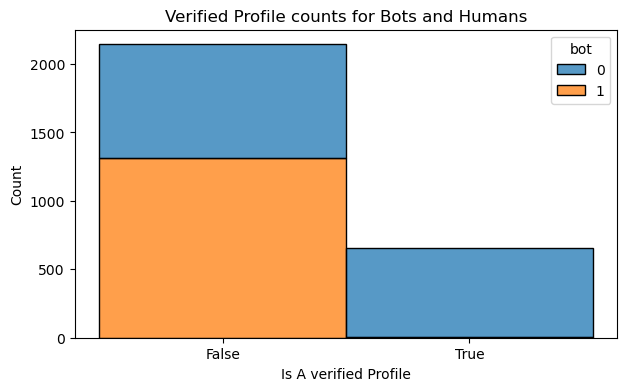

In [51]:
# Code block to plot - histogram plot between "verified" profile for Bots vs Humans
x = full_data['verified'].astype('str')
c = full_data['bot']
x_label = "Is A verified Profile"
y_label = "Count"
plot_title = "Verified Profile counts for Bots and Humans"

draw_histplot(x,c,full_data, x_label, y_label, plot_title)

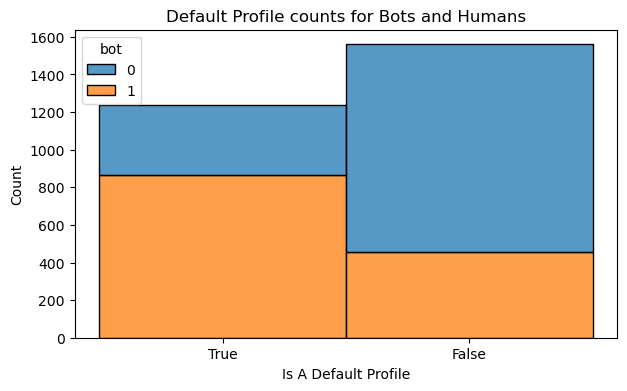

In [52]:
# Code block to plot - histogram plot between "default_profile" for Bots vs Humans
x = full_data['default_profile'].astype('str')
c = full_data['bot']
x_label = "Is A Default Profile"
y_label = "Count"
plot_title = "Default Profile counts for Bots and Humans"

draw_histplot(x,c,full_data, x_label, y_label, plot_title)

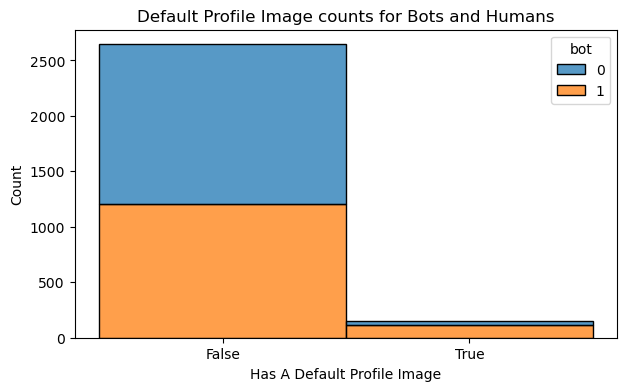

In [53]:
# Code block to plot - histogram plot between "default_profile_image" for Bot vs Humans
x = full_data['default_profile_image'].astype('str')
c = full_data['bot']
x_label = "Has A Default Profile Image"
y_label = "Count"
plot_title = "Default Profile Image counts for Bots and Humans"

draw_histplot(x,c,full_data, x_label, y_label, plot_title)

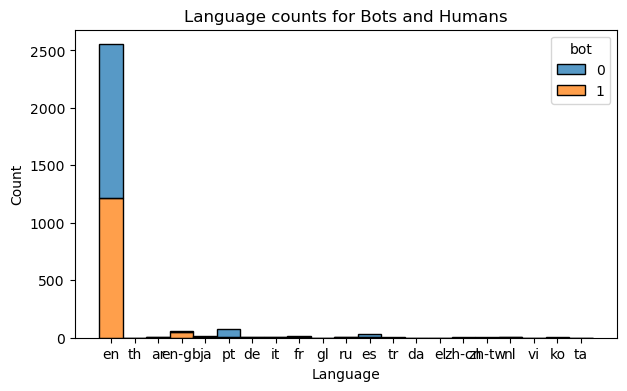

In [54]:
# Code block to plot - histogram plot between language counts for Bot vs Humans
x = full_data['lang'].astype('str')
c = full_data['bot']
x_label = "Language"
y_label = "Count"
plot_title = "Language counts for Bots and Humans"

draw_histplot(x,c,full_data, x_label, y_label, plot_title)

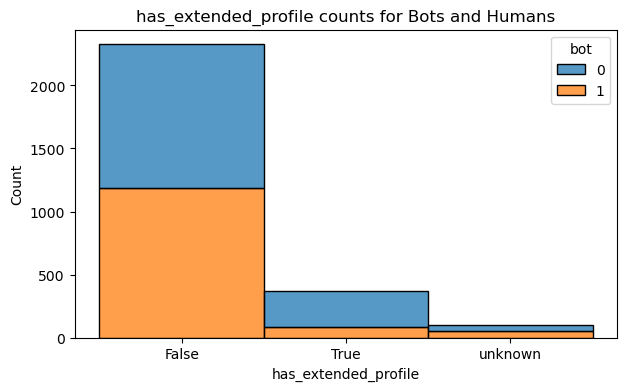

In [55]:
# Code block to plot - histogram plot for "has_extended_profile" extracted new feature between Bot vs Humans.
x = full_data['has_extended_profile'].astype('str')
c = full_data['bot']
x_label = "has_extended_profile"
y_label = "Count"
plot_title = "has_extended_profile counts for Bots and Humans"

draw_histplot(x,c,full_data, x_label, y_label, plot_title)

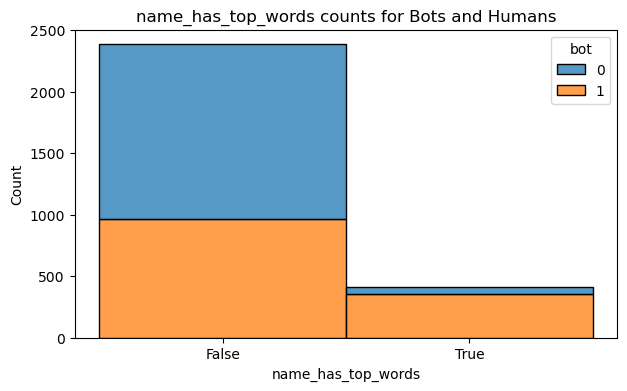

In [56]:
# Code block to plot - histogram plot for "name_has_top_words" extracted new feature between Bot vs Humans.
x = full_data['name_has_top_words'].astype('str')
c = full_data['bot']
x_label = "name_has_top_words"
y_label = "Count"
plot_title = "name_has_top_words counts for Bots and Humans"

draw_histplot(x,c,full_data, x_label, y_label, plot_title)

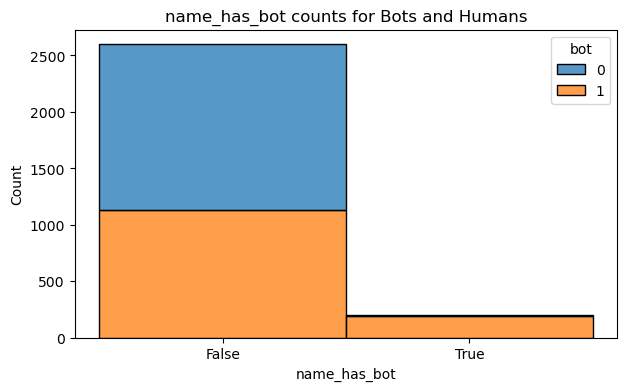

In [57]:
# Code block to plot - histogram plot for "name_has_bot" extracted new feature between Bot vs Humans.
x = full_data['name_has_bot'].astype('str')
c = full_data['bot']
x_label = "name_has_bot"
y_label = "Count"
plot_title = "name_has_bot counts for Bots and Humans"

draw_histplot(x,c,full_data, x_label, y_label, plot_title)

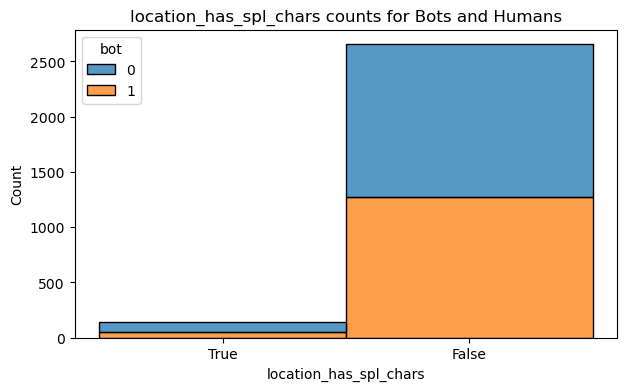

In [58]:
# Code block to plot - histogram plot for "location_has_spl_chars" extracted new feature between Bot vs Humans.
x = full_data['location_has_spl_chars'].astype('str')
c = full_data['bot']
x_label = "location_has_spl_chars"
y_label = "Count"
plot_title = "location_has_spl_chars counts for Bots and Humans"

draw_histplot(x,c,full_data, x_label, y_label, plot_title)

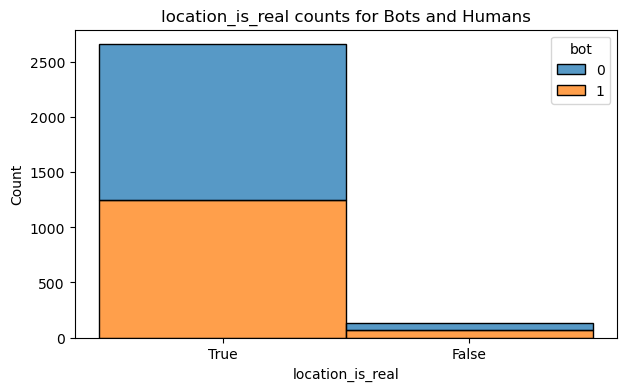

In [59]:
# Code block to plot - histogram plot for "location_is_real" extracted new feature between Bot vs Humans.
x = full_data['location_is_real'].astype('str')
c = full_data['bot']
x_label = "location_is_real"
y_label = "Count"
plot_title = "location_is_real counts for Bots and Humans"

draw_histplot(x,c,full_data, x_label, y_label, plot_title)

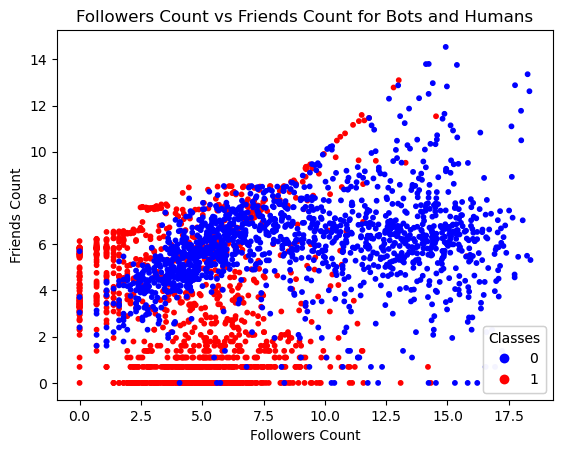

In [60]:
# Code block to plot - histogram plot for extracted new features, "followers_count" vs "friends_count" between Bot vs Humans.
x = full_data['followers_count'].apply(lambda x: np.log(x+1))
y = full_data['friends_count'].apply(lambda x: np.log(x+1))
c = full_data['bot']

x_label = "Followers Count"
y_label = "Friends Count"
plot_title = "Followers Count vs Friends Count for Bots and Humans"

draw_scatterplot(x,y,c, x_label, y_label, plot_title)

# Model Building

We can remove id column as we are not going to use it anywhere in model building.
Model expects feature values to be in boolean, integer encoded categorical features, or simple integer or floating values.

In [61]:
# Dropping "id" feature, as not going to use in model building.
full_data.drop("id", axis=1, inplace=True)

In [62]:
full_data.head()

,followers_count,friends_count,listed_count,favourites_count,verified,statuses_count,lang,default_profile,default_profile_image,has_extended_profile,...,name_has_bot,location_length,location_has_spl_chars,location_is_real,description_length,desc_has_top_words,desc_has_bot,has_url,has_status,created_at_year
0,1291,0,10,0,False,78554,en,True,False,False,...,False,13,True,True,12,False,False,True,True,2017
1,1,349,0,38,False,31,en,True,False,False,...,False,25,False,True,21,False,False,True,False,2016
2,1086,0,14,0,False,713,en,True,False,False,...,True,0,False,True,21,True,True,True,True,2015
3,33,0,8,0,False,676,en,True,True,False,...,False,0,False,True,0,False,False,True,True,2015
4,11,745,0,146,False,185,en,False,False,False,...,False,21,False,True,5,True,False,True,False,2015


In [63]:
full_data.has_extended_profile.value_counts()

False      2327
True        371
unknown      99
Name: has_extended_profile, dtype: int64

In [64]:
full_data.lang.value_counts()

en       2553
pt         79
en-gb      58
es         32
fr         15
ja         11
de         10
it          9
zh-cn       8
ar          5
ru          3
tr          2
zh-tw       2
nl          2
ko          2
th          1
da          1
el          1
gl          1
vi          1
ta          1
Name: lang, dtype: int64

In [65]:
## integer encoded categorical features
full_data.lang  = pd.Categorical(full_data.lang).codes
full_data.has_extended_profile  = pd.Categorical(full_data.has_extended_profile).codes

In [66]:
full_data.dtypes

followers_count           int64
friends_count             int64
listed_count              int64
favourites_count          int64
verified                   bool
statuses_count            int64
lang                       int8
default_profile            bool
default_profile_image      bool
has_extended_profile       int8
bot                       int64
screen_name_length        int64
name_length               int64
name_has_top_words         bool
name_has_bot               bool
location_length           int64
location_has_spl_chars     bool
location_is_real           bool
description_length        int64
desc_has_top_words         bool
desc_has_bot               bool
has_url                    bool
has_status                 bool
created_at_year           int64
dtype: object

### Machine Learning Models are run on data set with old features and with new features separately.

In [67]:
# List of new extracted fetaures post feature engineering.
new_features = ['screen_name_length', 'name_length', 'name_has_top_words',
       'name_has_bot', 'location_length', 'location_has_spl_chars',
       'location_is_real', 'description_length', 'desc_has_top_words',
       'desc_has_bot', 'has_url', 'has_status', 'created_at_year']

In [68]:
# Lis of old features which were part of original data set.
old_features = ['followers_count', 'friends_count', 'listed_count', 'favourites_count',
       'verified', 'statuses_count', 'lang', 'default_profile',
       'default_profile_image', 'has_extended_profile','bot']

In [69]:
old_features_df = full_data[old_features].copy()

### Train Test Split

In [70]:
# Features and Targets
old_X = old_features_df.drop(['bot'], axis=1)
old_y = old_features_df['bot']
old_X_train, old_X_test, old_y_train, old_y_test = train_test_split(old_X, old_y, test_size=0.20, random_state=42)

# Features and Targets
new_X = full_data.drop(['bot'], axis=1)
new_y = full_data['bot']
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.20, random_state=42)

### BaseLine Model - Logistic Regression

Train Metrics


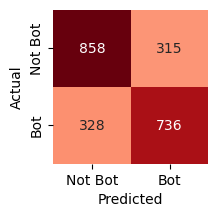

F1 Score 0.7
Precision Score 0.7
Recall Score 0.69
Accuracy Score 0.71


Test Metrics


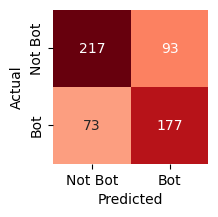

F1 Score 0.68
Precision Score 0.66
Recall Score 0.71
Accuracy Score 0.7


In [71]:
# Implmenting Logistic Regression on Old data set i.e., data set with old features.
old_lr = LogisticRegression()
old_lr_train_metrics, old_lr_test_metrics = fit_model_and_run_preds(old_lr, old_X_train, old_y_train, 
                                                                    old_X_test, old_y_test, 
                                                                    "Logistic Old Feat", True)

Train Metrics


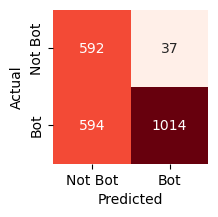

F1 Score 0.76
Precision Score 0.96
Recall Score 0.63
Accuracy Score 0.72


Test Metrics


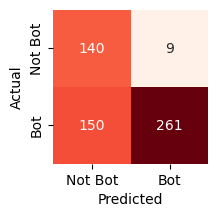

F1 Score 0.77
Precision Score 0.97
Recall Score 0.64
Accuracy Score 0.72


In [72]:
# Implmenting Logistic Regression on New data set i.e., data set with new extracted features.
new_lr = LogisticRegression()
new_lr_train_metrics, new_lr_test_metrics = fit_model_and_run_preds(new_lr, new_X_train, new_y_train, 
                                                                    new_X_test, new_y_test, 
                                                                    "Logistic New Feat", True)

### Support Vector Machines Model

Train Metrics


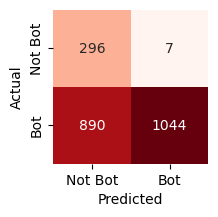

F1 Score 0.7
Precision Score 0.99
Recall Score 0.54
Accuracy Score 0.6


Test Metrics


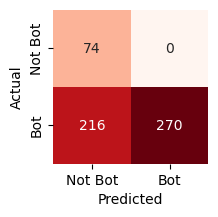

F1 Score 0.71
Precision Score 1.0
Recall Score 0.56
Accuracy Score 0.61


In [73]:
# Implmenting SVM on Old data set i.e., data set with old features.
old_svc = SVC(probability=True)
old_svc_train_metrics, old_svc_test_metrics = fit_model_and_run_preds(old_svc, old_X_train, old_y_train, 
                                                                      old_X_test, old_y_test, 
                                                                      "SVM Old Feat", True)

Train Metrics


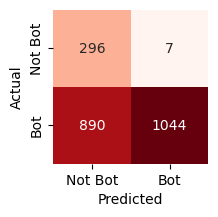

F1 Score 0.7
Precision Score 0.99
Recall Score 0.54
Accuracy Score 0.6


Test Metrics


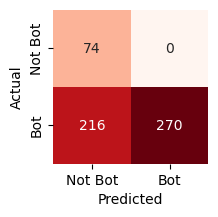

F1 Score 0.71
Precision Score 1.0
Recall Score 0.56
Accuracy Score 0.61


In [74]:
# Implmenting SVM on New data set i.e., data set with new extracted features.
new_svc = SVC(probability=True)
new_svc_train_metrics, new_svc_test_metrics = fit_model_and_run_preds(new_svc, new_X_train, new_y_train, 
                                                                      new_X_test, new_y_test, 
                                                                      "SVM New Feat", True)

### Random Forest Classifer Model

Train Metrics


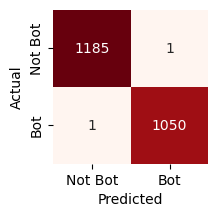

F1 Score 1.0
Precision Score 1.0
Recall Score 1.0
Accuracy Score 1.0


Test Metrics


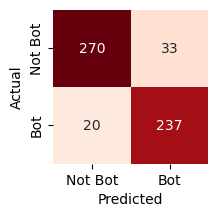

F1 Score 0.9
Precision Score 0.88
Recall Score 0.92
Accuracy Score 0.91


In [75]:
# Implmenting Random Forest Classifier on Old data set i.e., dataset with old features.
old_rf = RandomForestClassifier()
old_rf_train_metrics, old_rf_test_metrics = fit_model_and_run_preds(old_rf, old_X_train, old_y_train, 
                                                                    old_X_test, old_y_test, 
                                                                    "RF Old Feat", True)

Train Metrics


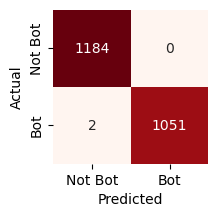

F1 Score 1.0
Precision Score 1.0
Recall Score 1.0
Accuracy Score 1.0


Test Metrics


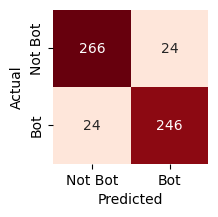

F1 Score 0.91
Precision Score 0.91
Recall Score 0.91
Accuracy Score 0.91


In [76]:
# Implmenting Random Forest Classifier on New data set i.e., data set with new extracted features.
new_rf = RandomForestClassifier()
new_rf_train_metrics, new_rf_test_metrics = fit_model_and_run_preds(new_rf, new_X_train, new_y_train, 
                                                                    new_X_test, new_y_test, 
                                                                    "RF New Feat", True)

## XgBoost Model

Train Metrics


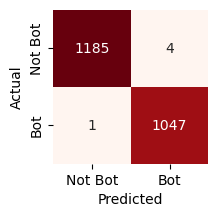

F1 Score 1.0
Precision Score 1.0
Recall Score 1.0
Accuracy Score 1.0


Test Metrics


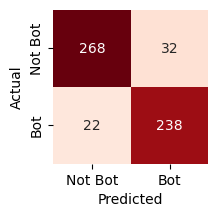

F1 Score 0.9
Precision Score 0.88
Recall Score 0.92
Accuracy Score 0.9


In [77]:
# Implmenting XGBoost on Old data set i.e., data set with old features.
old_xgb = xgb.XGBClassifier()
old_xgb_train_metrics, old_xgb_test_metrics = fit_model_and_run_preds(old_xgb, old_X_train, old_y_train, 
                                                                      old_X_test, old_y_test, 
                                                                      "XGB Old Feat", True)

Train Metrics


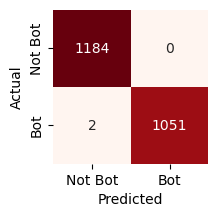

F1 Score 1.0
Precision Score 1.0
Recall Score 1.0
Accuracy Score 1.0


Test Metrics


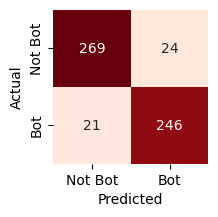

F1 Score 0.92
Precision Score 0.91
Recall Score 0.92
Accuracy Score 0.92


In [78]:
# Implmenting XGBoost on New data set i.e., data set with new extracted features.
new_xgb = xgb.XGBClassifier()
new_xgb_train_metrics, new_xgb_test_metrics = fit_model_and_run_preds(new_xgb, new_X_train, new_y_train, 
                                                                      new_X_test, new_y_test, 
                                                                      "XGB New Feat", True)

## Fine Tuning the Models

## Random Forest Classifier Fine Tuning

Best score: 0.9213296979865773
Best params: {'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 800}
Train Metrics


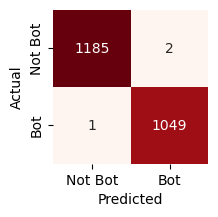

F1 Score 1.0
Precision Score 1.0
Recall Score 1.0
Accuracy Score 1.0


Test Metrics


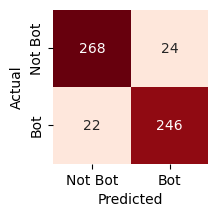

F1 Score 0.91
Precision Score 0.91
Recall Score 0.92
Accuracy Score 0.92


In [83]:
# Hyper parameters considered for fine tuning Random Forest Classifier model.
params = {
    'n_estimators': [100, 200, 500, 800],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5,7,9,12,15]
}


# GridSearchCV() is called for RandomForestClassifier for all the Hyper parameters to find the optimal parameter values.
rf_grid_search = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=5),scoring='accuracy')
rf_grid_search.fit(new_X_train, new_y_train)

# Display the best parameters and its score.
print('Best score:', rf_grid_search.best_score_)
print('Best params:', rf_grid_search.best_params_)

best_rf_model = rf_grid_search.best_estimator_
best_rf_train_metrics, best_rf_test_metrics = fit_model_and_run_preds(best_rf_model, new_X_train, new_y_train, 
                                                                      new_X_test, new_y_test, 
                                                                      "RF Best Model", True)

## XGBoost Classifier Fine Tuning

Best score: 0.927585690316395
Best params: {'base_score': 0.5, 'booster': 'gbtree', 'gamma': 0, 'learning_rate': 0.05, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.5}
Train Metrics


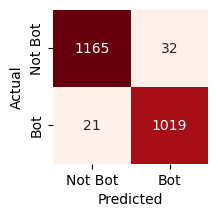

F1 Score 0.97
Precision Score 0.97
Recall Score 0.98
Accuracy Score 0.98


Test Metrics


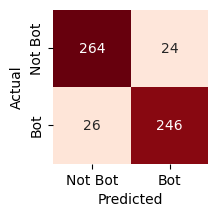

F1 Score 0.91
Precision Score 0.91
Recall Score 0.9
Accuracy Score 0.91


In [84]:
# Hyper parameters considered for fine tuning XGBoost Classifier model.
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 1]
}

# GridSearchCV() is called for XGBClassifier for all the Hyper parameters to find the optimal parameter values.
xgb_grid_search = GridSearchCV(xgb.XGBClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=5), scoring='accuracy')
xgb_grid_search.fit(new_X_train, new_y_train)

# Display best parameters and its score.
print('Best score:', xgb_grid_search.best_score_)
print('Best params:', xgb_grid_search.best_params_)

best_xgb_model = xgb_grid_search.best_estimator_
best_xgb_train_metrics, best_xgb_test_metrics = fit_model_and_run_preds(best_xgb_model, new_X_train, new_y_train, 
                                                                        new_X_test, new_y_test, 
                                                                        "XGB Best Model", True)

# Collecting metrics of all the models and plotting ROC-AUC curve.

In [81]:
# All the metric information of each model is gathered.
metrics_list = [new_xgb_test_metrics, old_xgb_test_metrics, 
new_rf_test_metrics, old_rf_test_metrics,
new_svc_test_metrics, old_svc_test_metrics,
new_lr_test_metrics,old_lr_test_metrics,
best_rf_test_metrics, best_xgb_test_metrics]

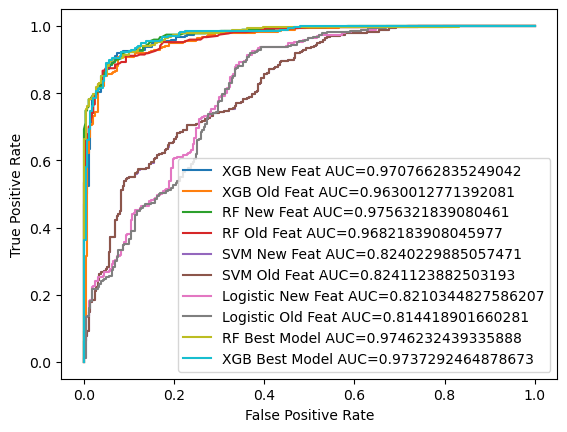

In [82]:
# plotting ROC curve for each model against dat with new and old features, along with tuned models with data with new feature.
for metric in metrics_list:
    plt.plot(metric['fpr'],metric['tpr'],
         label=metric['model_desc']+" AUC="+str(metric['auc']))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show() 